In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [6]:
df = pd.read_excel("../data/raw/premiums_young_with_gr.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4


In [7]:
df.shape

(20096, 14)

In [8]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [9]:
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount', 'genetical_risk'],
      dtype='object')

In [10]:
# check missing values
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [11]:
# drop rows with missing values
df.dropna(inplace=True)

In [12]:
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [13]:
# check duplicates
df.duplicated().sum()
# drop duplicates
df.drop_duplicates(inplace=True)

In [14]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267,2.503932
std,2.294052,0.940713,23.420493,2749.906347,1.710203
min,18.000000,-3.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


In [15]:
# handling negative values in number_of_dependants
df[df['number_of_dependants'] < 0].shape

(22, 14)

In [16]:
# transform negative values to positive
df['number_of_dependants'] = df['number_of_dependants'].abs()

In [17]:
df['number_of_dependants'].min()

np.int64(0)

In [18]:
# numeric columns
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

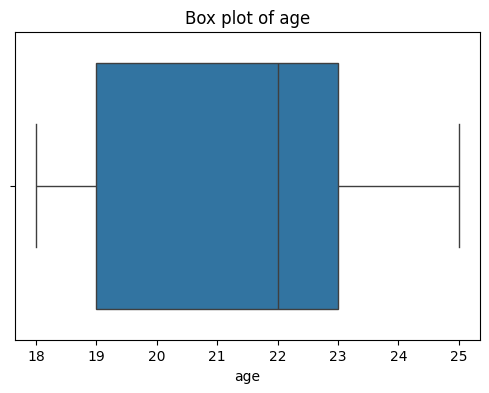

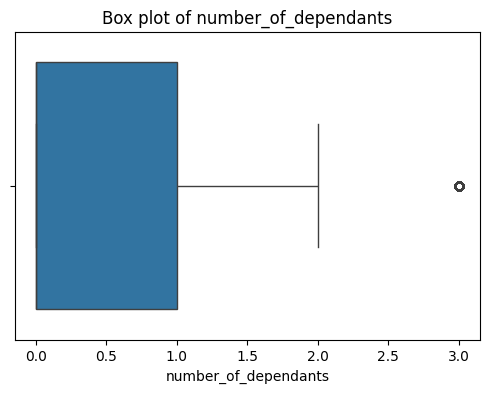

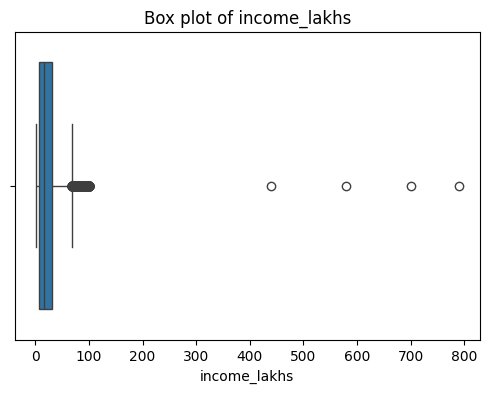

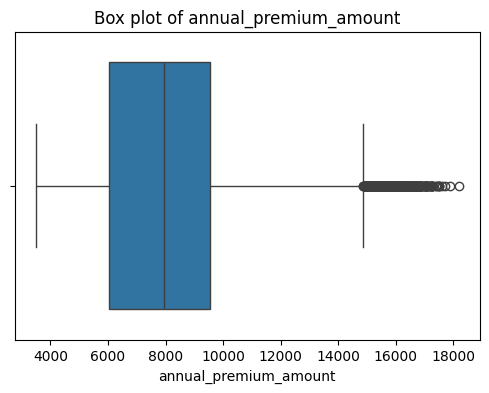

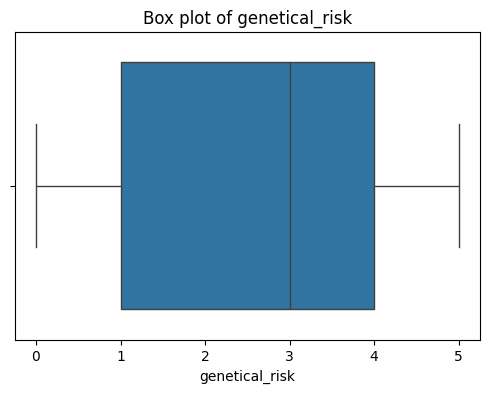

In [19]:
# print box plots for numeric columns
for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Box plot of {col}')
    plt.show()

In [20]:
# find age more than 100
df[df.age > 100]['age'].unique()

array([], dtype=int64)

In [21]:
# drop the age more than 100
df1 = df[df.age <= 100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267,2.503932
std,2.294052,0.937200,23.420493,2749.906347,1.710203
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


In [22]:
 # calculate quantiles for income
df1.income_lakhs.quantile([0.25, 0.5, 0.75, 0.95, 0.99])

0.25     6.0
0.50    16.0
0.75    31.0
0.95    75.0
0.99    95.0
Name: income_lakhs, dtype: float64

In [23]:
# get iqr bounds
def get_iqr_bounds(col):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

In [24]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

np.float64(100.0)

In [25]:
# find how many rows have income more than this threshold
df1[df1.income_lakhs > quantile_threshold].shape

(4, 14)

In [26]:
# drop rows with income more than this threshold
df2 = df1[df1.income_lakhs <= quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263,2.503883
std,2.294248,0.937238,21.732062,2749.912486,1.710184
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.000000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,100.000000,18186.000000,5.000000


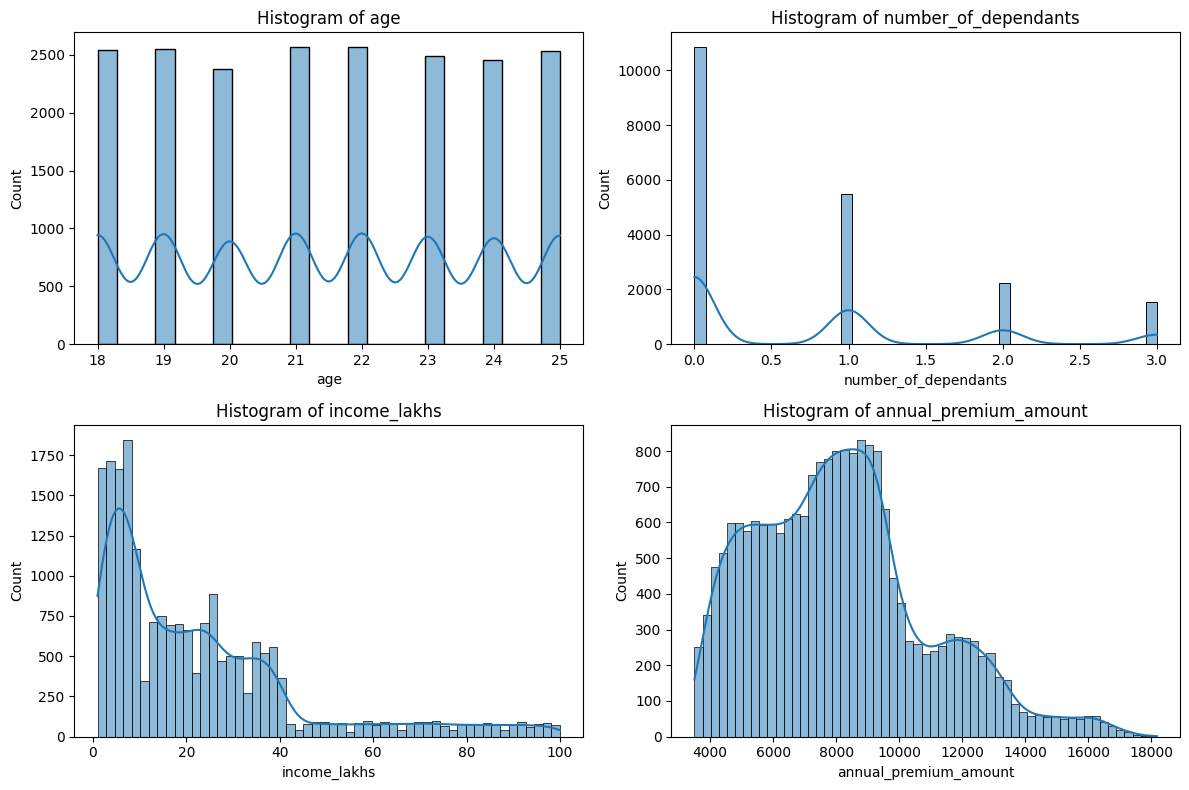

In [27]:
# print distribution with histogram but in 2 rows
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(numeric_columns[:4]):
    sns.histplot(df2[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')

plt.tight_layout()
plt.show()


<Axes: xlabel='age', ylabel='annual_premium_amount'>

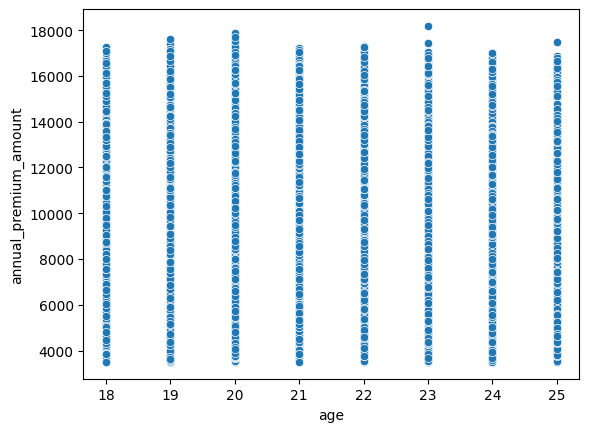

In [28]:
sns.scatterplot(x='age', y='annual_premium_amount', data=df2)

In [29]:
# select all categorical columns
categorical_columns = df2.select_dtypes(include=['object']).columns
categorical_columns

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [30]:
# print unique values of categorical columns
for col in categorical_columns:
    print(col, df2[col].unique())

gender ['Male' 'Female']
region ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status ['Unmarried' 'Married']
bmi_category ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status ['Self-Employed' 'Freelancer' 'Salaried']
income_level ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan ['Silver' 'Bronze' 'Gold']


In [31]:
df2['smoking_status'] = df['smoking_status'].copy()

In [32]:
df2['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional', 'Smoking=0',
       'Does Not Smoke', 'Not Smoking'], dtype=object)

In [33]:
df2['smoking_status'].replace({
    'Smoking=0': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Not Smoking': 'No Smoking'
}, inplace=True)

/tmp/ipykernel_176590/3470280459.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['smoking_status'].replace({


In [34]:
df2['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

In [35]:
pct_count = df2['gender'].value_counts(normalize=True) * 100

<Axes: xlabel='gender'>

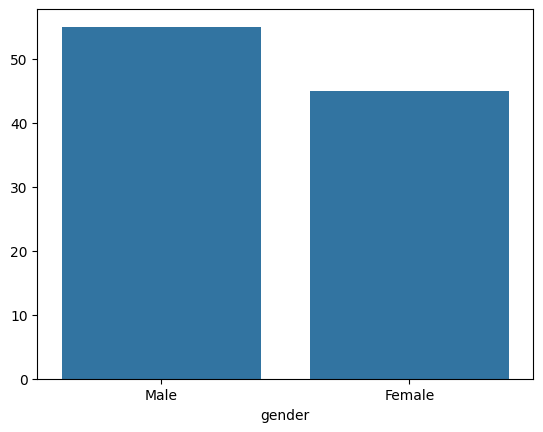

In [36]:
# bar plot for gender
sns.barplot(x=pct_count.index, y=pct_count.values)

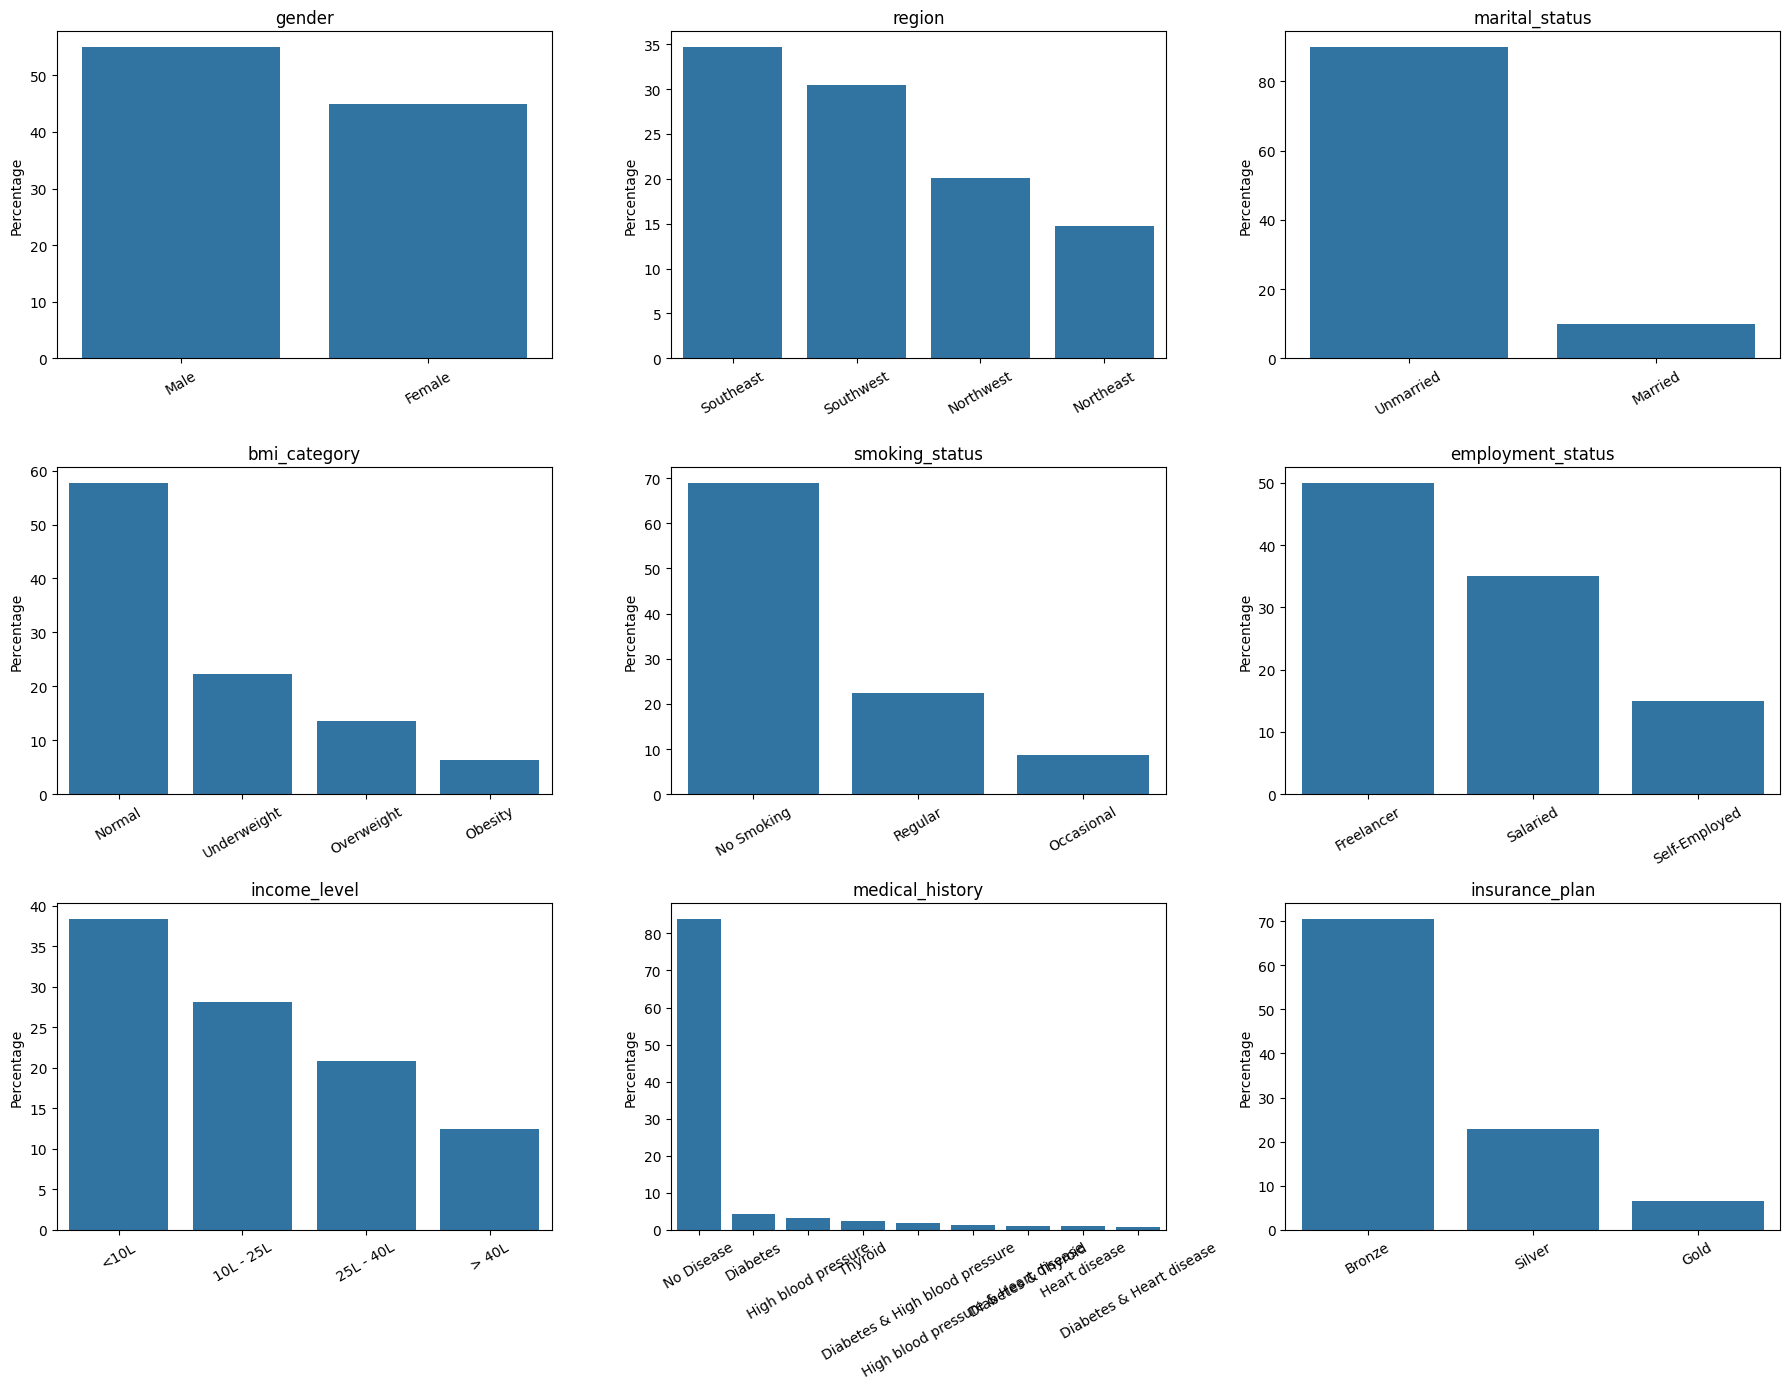

In [37]:
# plot bar plot for all catagorical columns
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

for i, col in enumerate(categorical_columns[:9]):  # limit to 9
    pct_count = df2[col].value_counts(normalize=True) * 100

    sns.barplot(
        x=pct_count.index,
        y=pct_count.values,
        ax=axes[i]
    )

    axes[i].set_title(col)
    axes[i].set_ylabel("Percentage")
    axes[i].set_xlabel("")
    axes[i].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

In [38]:
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])

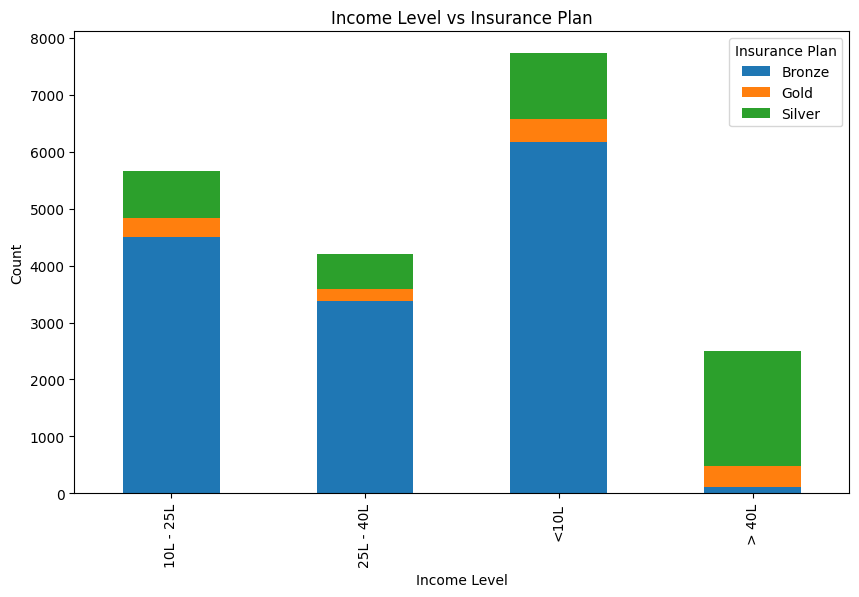

In [39]:
crosstab.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Income Level vs Insurance Plan')
plt.xlabel('Income Level')
plt.ylabel('Count')
plt.legend(title='Insurance Plan')
plt.show()

In [40]:
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4


In [41]:
# saved cleaned df for feature engineering
df2.to_csv("../data/raw/df2_cleaned_young_gr.csv", index=False)